# BiteMe | Exploratory Data Analysis

In this notebook we analyse our images to help inform modelling.

Here are some questions and identified complexities I have about this project:
 - Sample sizes are very small. This should be considered as a few-shot learning problem. Can we generate new training images?
 - Data have been collected by non-clinicians. Mis-labelled images might exist in an already small dataset.
 - Other classes exist (spiders, lice etc.)
 - Intra classes exist (bees vs hornets)
 - Skin tone is not addressed - the dataset is wholly white skin as I could not source any other skin tones. No class images therefore had to be solely white skinned too. 
 - Skin tone regardless of ethnicity is difficult regardless. The image recognition will largely be dependent on hue, so we can't mitigate this complexity by turning images to grayscale.
 - No class images are hard to source and have questions. Do we include plain images with no bites? Do we include other dermatological conditions (e.g. acne, moles) to challenge the algorithm?
 
This is not a standard image classification task, it is a Fine-Grained Visual Classification (FGVC) task as the classes are difficult to distinguish images of similar classes. Furthermore, there are multiple stages to this problem:

 1. Object detection to find a bite(s) and distinguish between other dermatological conditions.
 2. FGVC of detected bite to determine class. 
 
As images will be variable in how they have been taken, and the information presented in images are subtly different (often indistinguishable by humans), passing an image directly to a classifier likely will not be enough. We will try this nonetheless as a first version, but the more likely architecture will require an object detection layer followed by an FGVC layer. 

Papers:
 - [Reinforcing Generated Images via Meta-learning
for One-Shot Fine-Grained Visual Recognition](https://arxiv.org/pdf/2204.10689.pdf).
 - [Few-shot Object Detection via Feature Reweighting](https://paperswithcode.com/paper/few-shot-object-detection-via-feature)
 - 

In [1]:
import pandas as pd
import numpy as np
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn

import cv2
import albumentations as A
import imgaug as ia
import imgaug.augmenters as iaa

sys.path.append("..")
from utils.utils import read_images, display_img
from utils.constants import ROWS, COLS, CHANNELS, SEED

plt.rcParams["figure.figsize"] = (12, 6)

np.random.seed(SEED)
ia.seed(SEED)

In [2]:
# Define directories
base_dir_path = "../"

data_dir_path = os.path.join(base_dir_path, "data")
data_raw_dir_path = os.path.join(data_dir_path, "raw")
data_cleaned_dir_path = os.path.join(data_dir_path, "cleaned")

data_dir = os.listdir(data_dir_path)
data_raw_dir = os.listdir(data_raw_dir_path)
data_cleaned_dir = os.listdir(data_cleaned_dir_path)

metadata_path = os.path.join(data_cleaned_dir_path, "metadata.csv")
metadata = pd.read_csv(metadata_path)

metadata.head()

,img_name,img_path,label
0,7059b14d2aa03ed6c4de11afa32591995181d31c.jpg,../data/cleaned/none/7059b14d2aa03ed6c4de11afa...,none
1,ea1b100b581fcdb7ddfae52cc62347a99e304ba4.jpg,../data/cleaned/none/ea1b100b581fcdb7ddfae52cc...,none
2,6eac051b9c45ff6821ec8675216f371711b7cea9.jpg,../data/cleaned/none/6eac051b9c45ff6821ec86752...,none
3,fc72767f8520df9b2b83941077dc0ee013eb9399.jpg,../data/cleaned/none/fc72767f8520df9b2b8394107...,none
4,49850884a00703afe5aab78c3ce074d2d4acae30.jpg,../data/cleaned/none/49850884a00703afe5aab78c3...,none


In [3]:
metadata.value_counts("label")

label
bedbug      65
tick        61
ant         51
mosquito    51
none        30
horsefly    28
mite        24
bee         23
dtype: int64

In [4]:
print(f"Number of images: {len(metadata)}")

Number of images: 333


In [5]:
img_array = read_images(
    data_dir_path=data_cleaned_dir_path, # Set to cleaned dir as not writing images
    rows=ROWS, 
    cols=COLS, 
    channels=CHANNELS, 
    write_images=False, 
    output_data_dir_path=data_cleaned_dir_path
)
print(f"Image array shape: {img_array.shape}")

Reading images from: ../data/cleaned
Rows set to 1024
Columns set to 1024
Channels set to 3
Writing images is set to: False
Reading images...


0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 51/51 [00:11<00:00,  4.55it/s]


Image reading complete.
Image array shape: (333, 1024, 1024, 3)
Image array shape: (333, 1024, 1024, 3)


### Image Channels

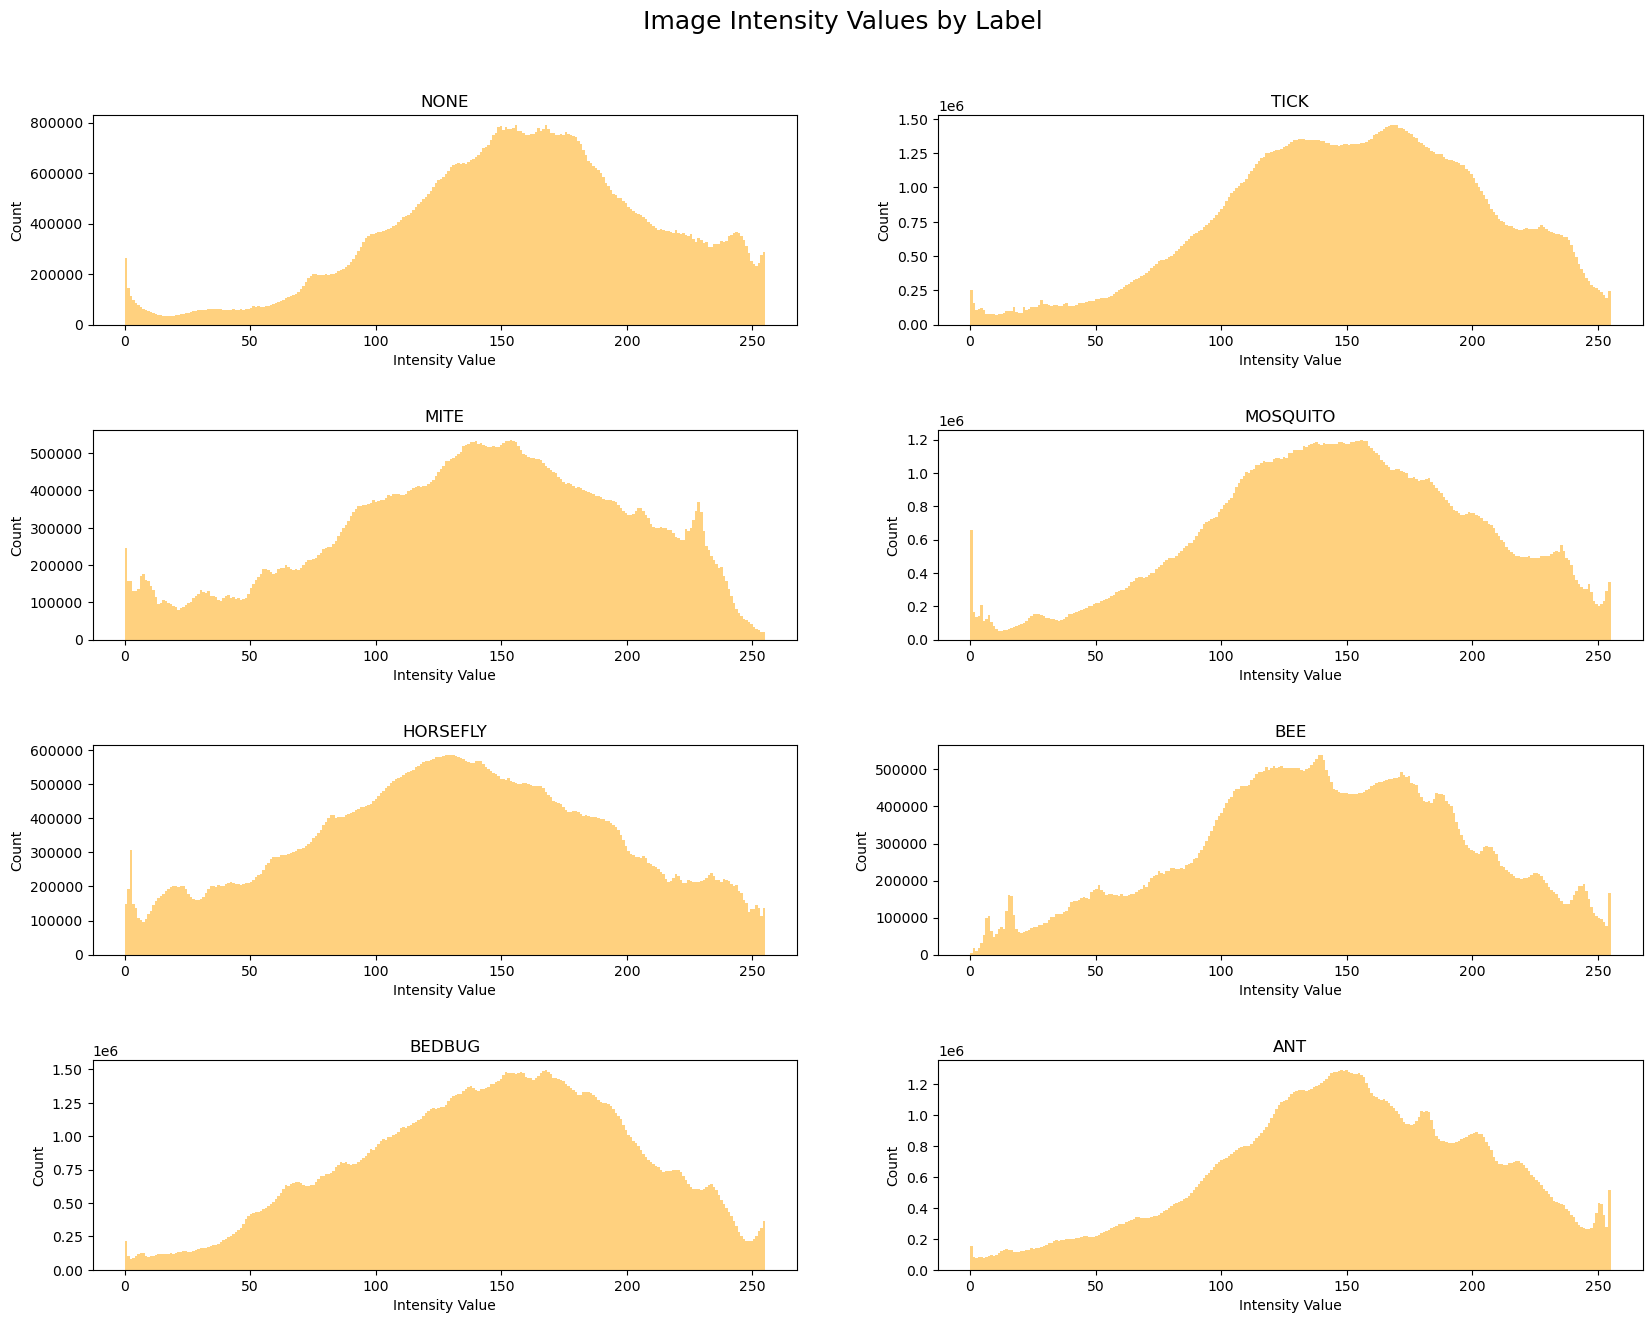

In [6]:
# Plot intensity values by label
labels = metadata["label"].unique()

fig, axs = plt.subplots(nrows=int(len(labels)/2), ncols=2, figsize=(20, 15))
fig.suptitle("Image Intensity Values by Label", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

for label, ax in zip(labels, axs.ravel()):
    # Subset img array to each label
    img_array_subset = img_array[metadata.loc[metadata.label == label].index]
    # Prepare arrays for channel values
    img_vals = np.empty(0)
    
    # Append image label subset values to channel arrays
    for idx, img in enumerate(img_array_subset):
        img_vals = np.append(img_vals, img_array_subset[idx].ravel())

    ax.hist(img_vals, bins = 256, color = "orange", alpha=0.5)
    ax.set_title(label.upper())
    ax.set_xlabel("Intensity Value")
    ax.set_ylabel("Count")

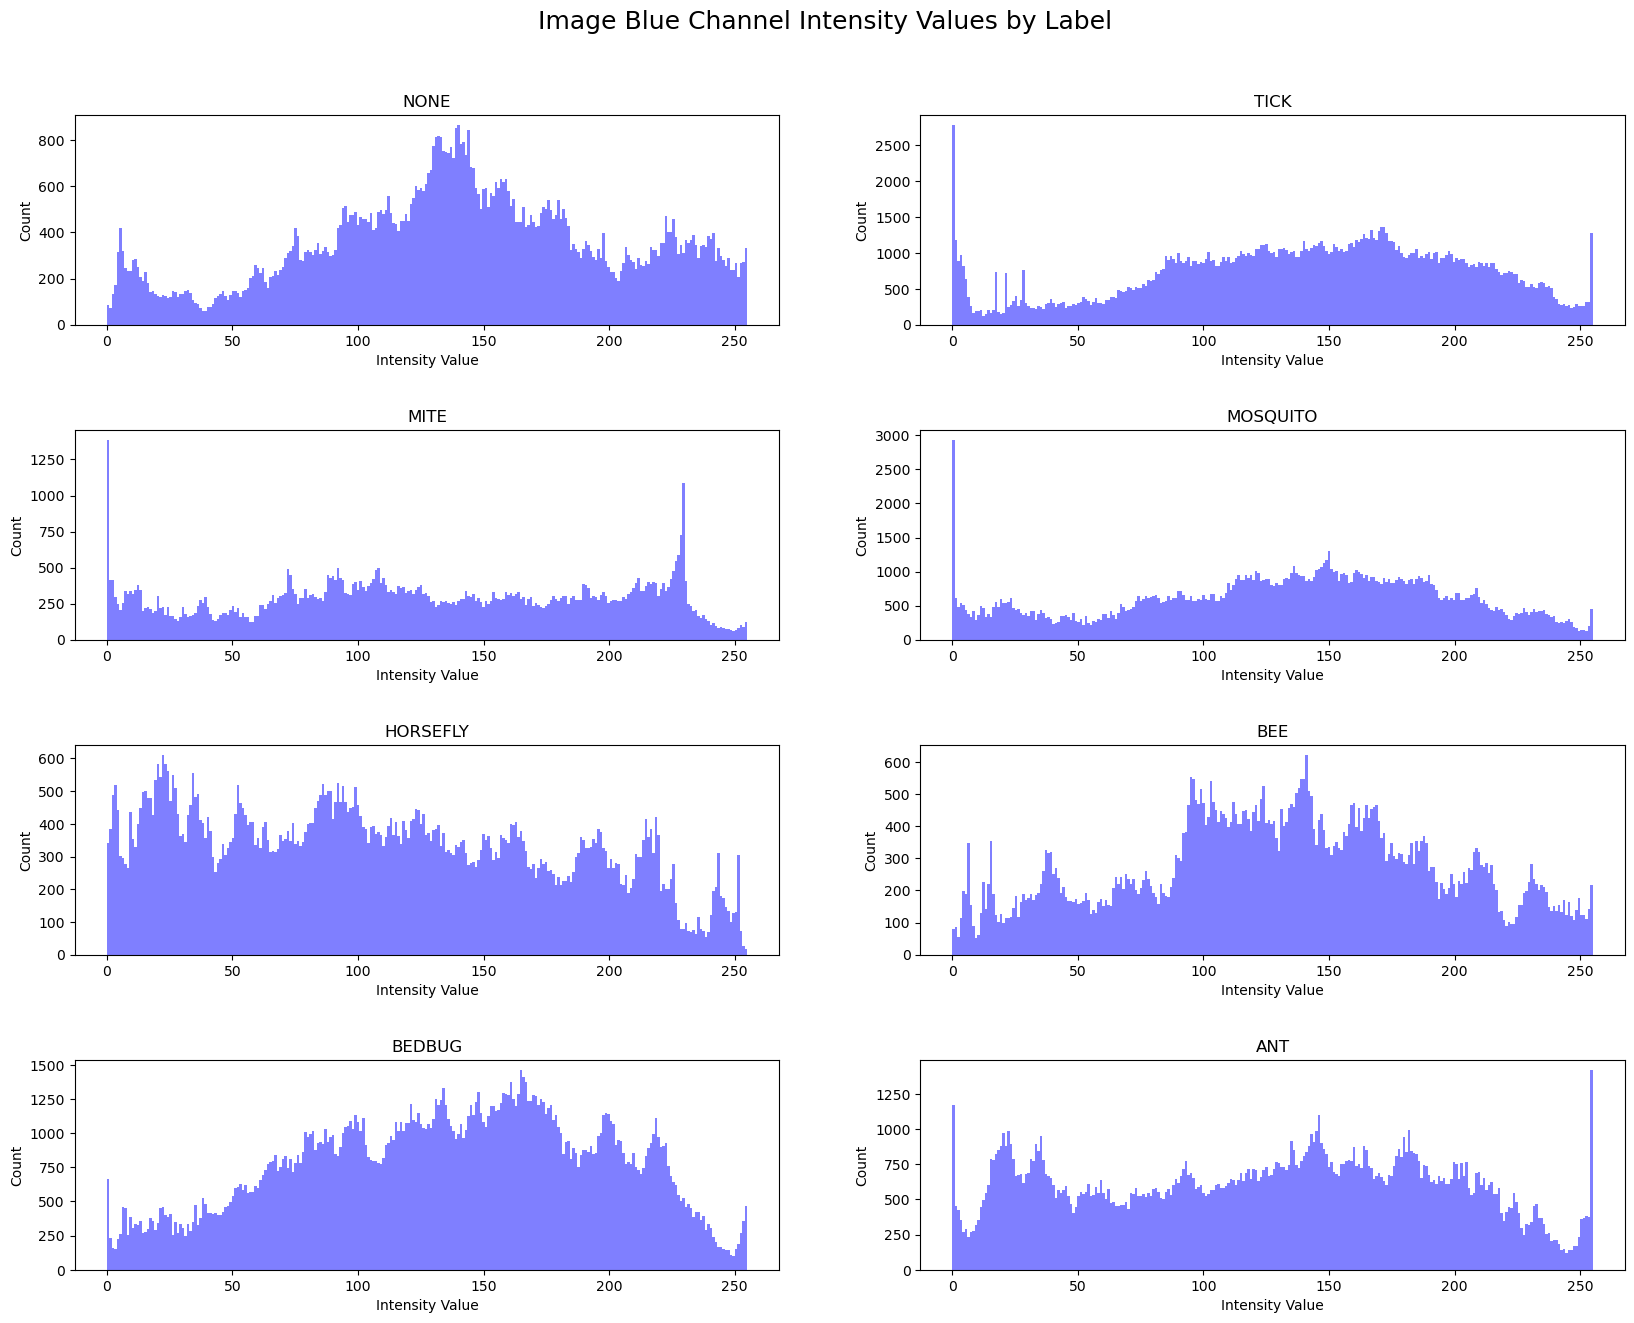

In [7]:
# Plot intensity values by label
labels = metadata["label"].unique()

fig, axs = plt.subplots(nrows=int(len(labels)/2), ncols=2, figsize=(20, 15))
fig.suptitle("Image Blue Channel Intensity Values by Label", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

for label, ax in zip(labels, axs.ravel()):
    # Subset img array to each label
    img_array_subset = img_array[metadata.loc[metadata.label == label].index]
    # Prepare arrays for channel values
    img_vals_b = np.empty(0)
    
    # Append image label subset values to channel arrays
    for idx, img in enumerate(img_array_subset):
        img_vals_b = np.append(img_vals_b, img_array_subset[idx, :, 0].ravel())

    ax.hist(img_vals_b, bins=256, color="blue", alpha=0.5)
    ax.set_title(label.upper())
    ax.set_xlabel("Intensity Value")
    ax.set_ylabel("Count")

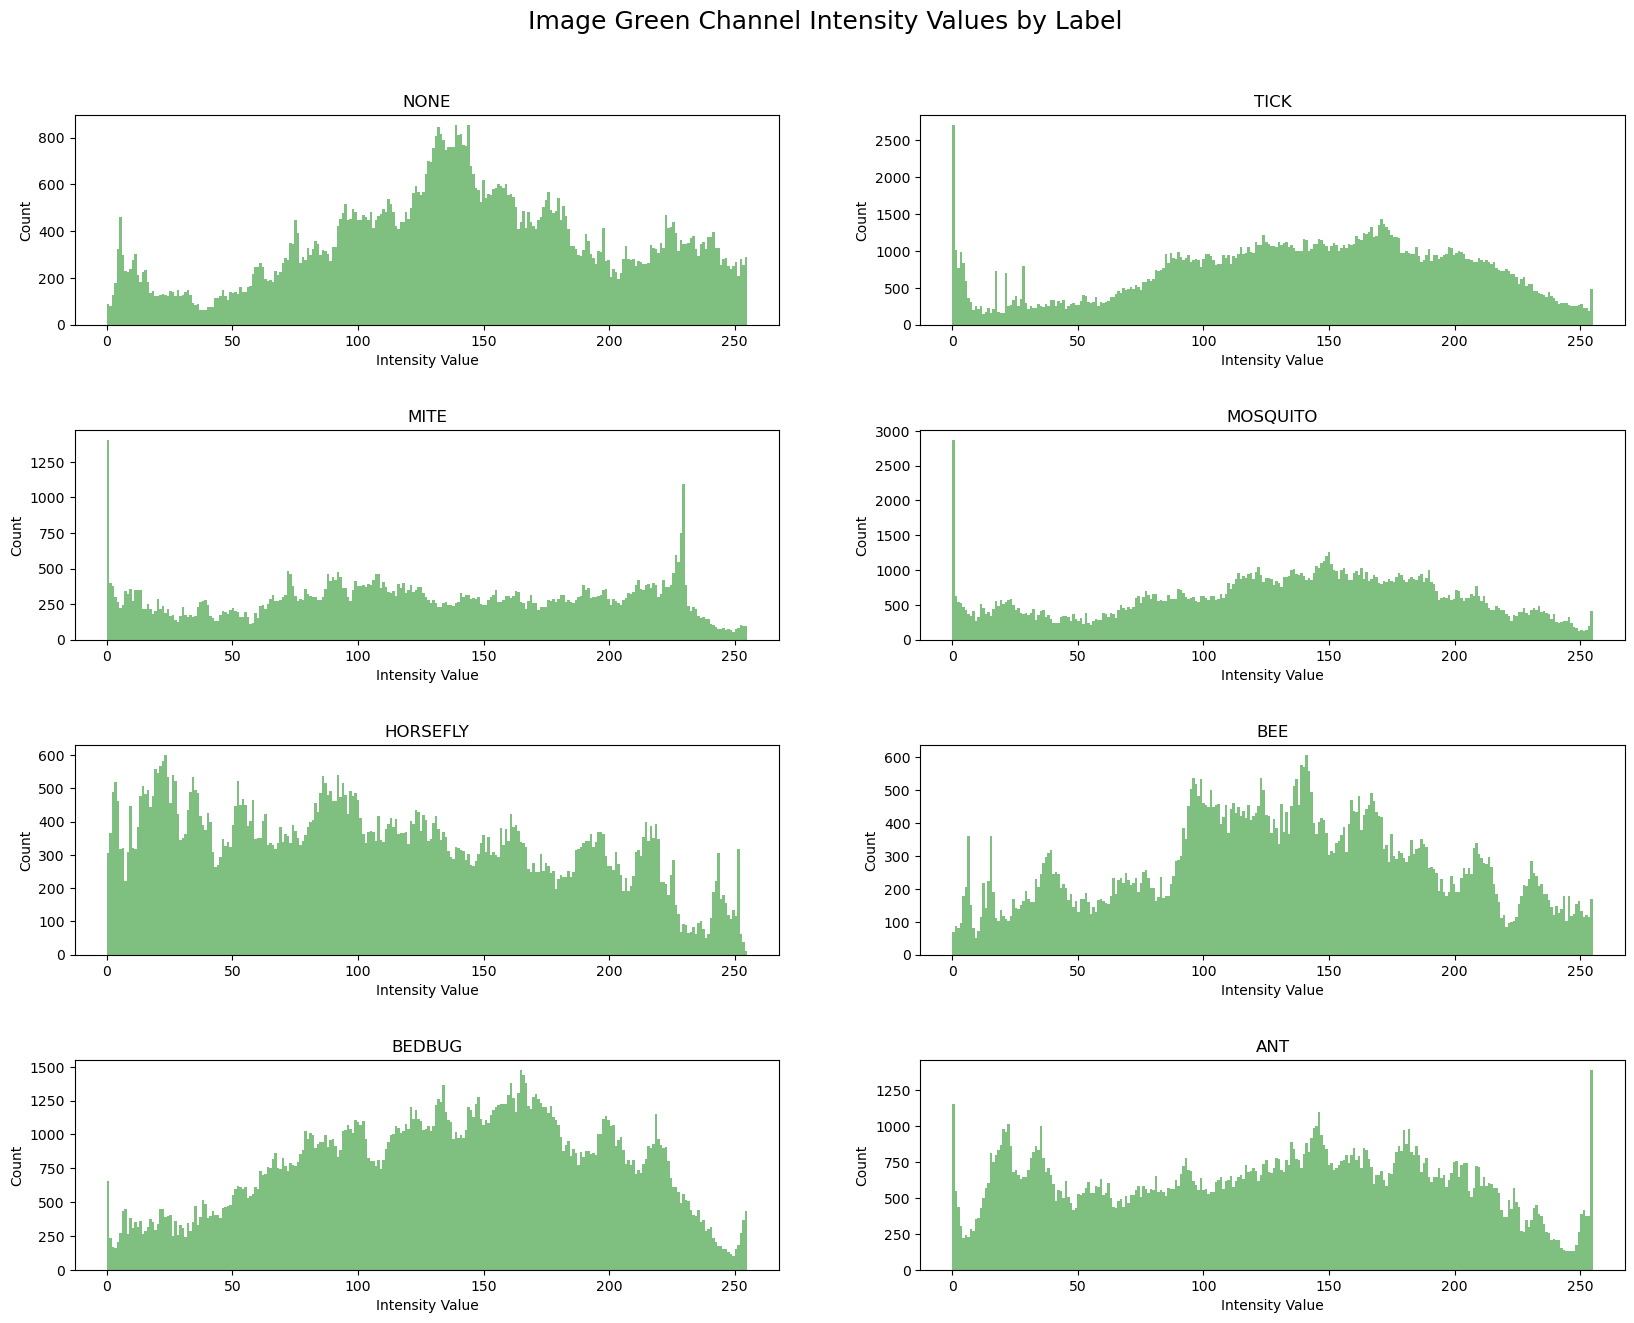

In [8]:
# Plot intensity values by label
labels = metadata["label"].unique()

fig, axs = plt.subplots(nrows=int(len(labels)/2), ncols=2, figsize=(20, 15))
fig.suptitle("Image Green Channel Intensity Values by Label", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

for label, ax in zip(labels, axs.ravel()):
    # Subset img array to each label
    img_array_subset = img_array[metadata.loc[metadata.label == label].index]
    # Prepare arrays for channel values
    img_vals_g = np.empty(0)
    
    # Append image label subset values to channel arrays
    for idx, img in enumerate(img_array_subset):
        img_vals_g = np.append(img_vals_g, img_array_subset[idx, :, 1].ravel())

    ax.hist(img_vals_g, bins=256, color="green", alpha=0.5)
    ax.set_title(label.upper())
    ax.set_xlabel("Intensity Value")
    ax.set_ylabel("Count")

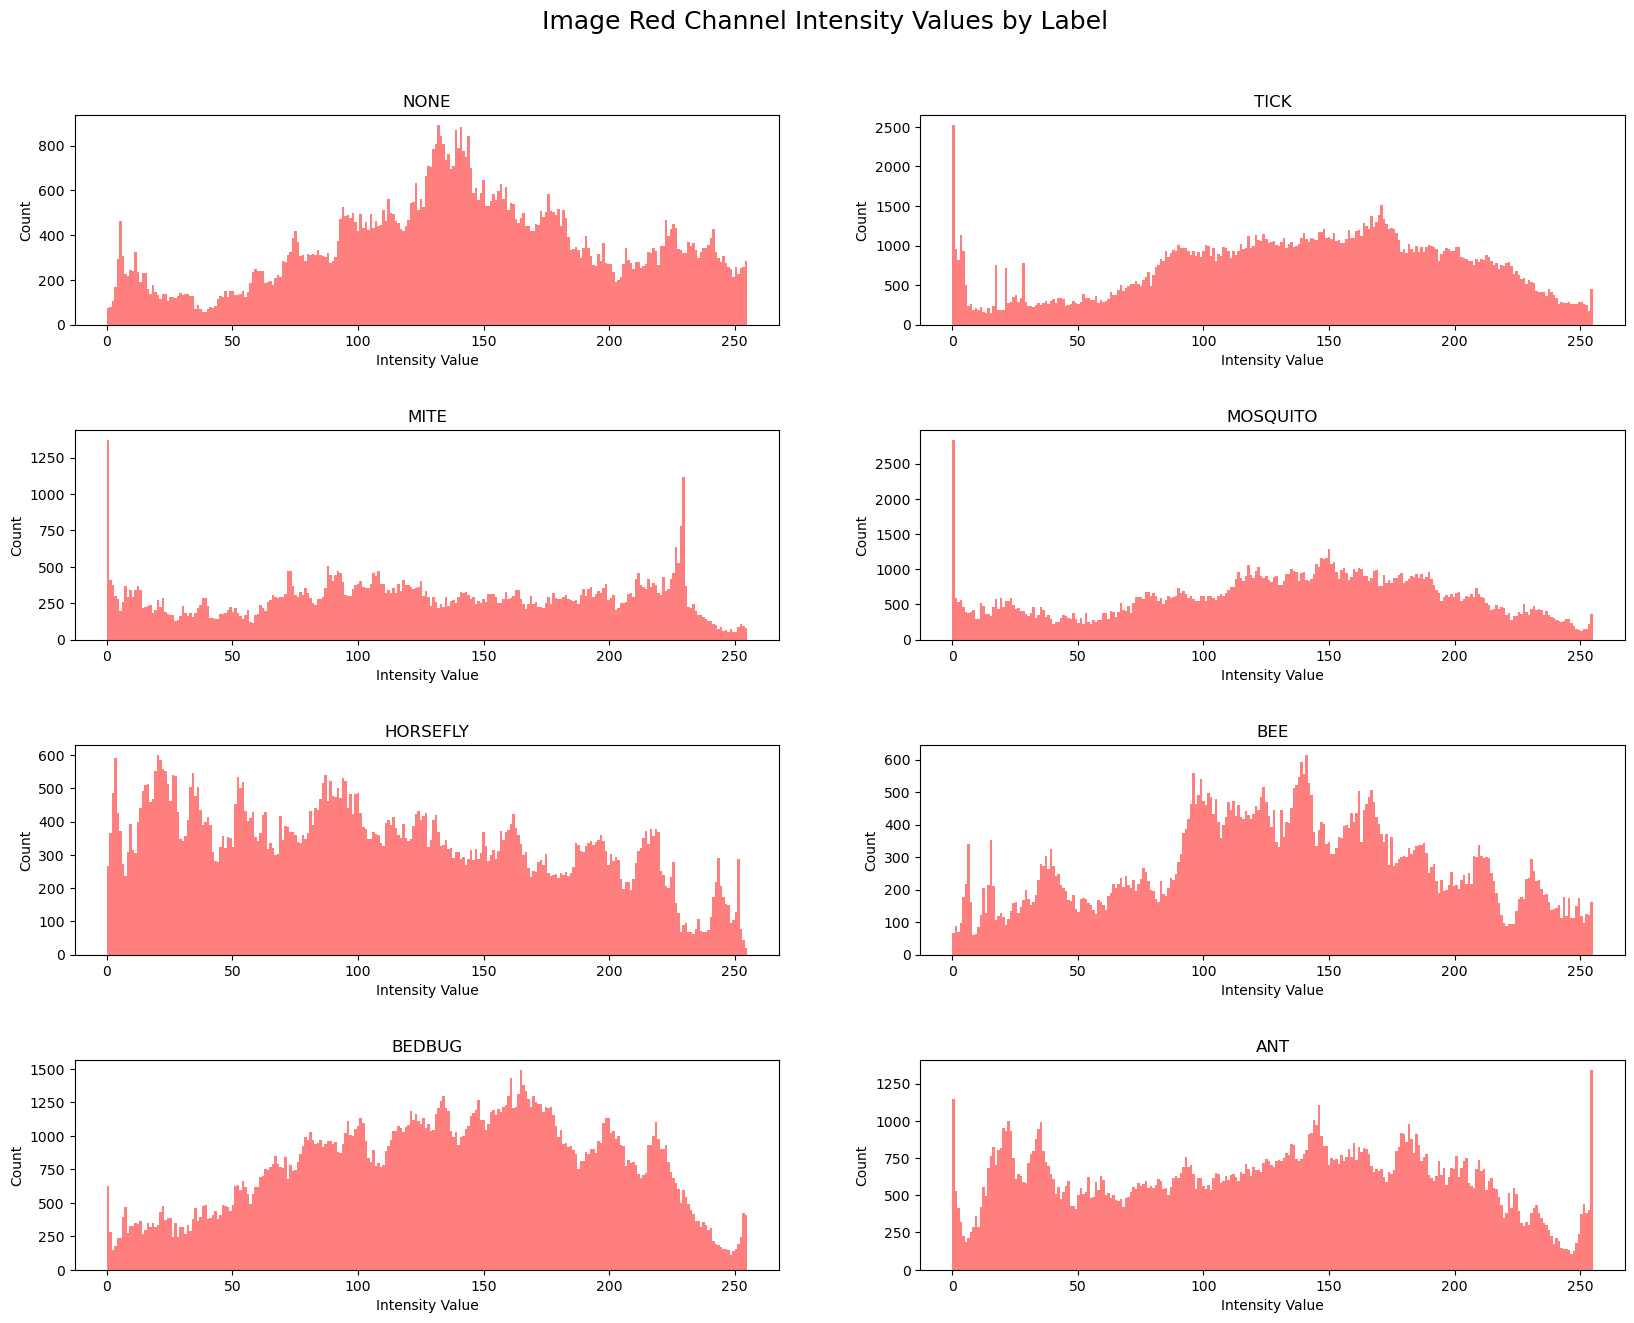

In [9]:
# Plot intensity values by label
labels = metadata["label"].unique()

fig, axs = plt.subplots(nrows=int(len(labels)/2), ncols=2, figsize=(20, 15))
fig.suptitle("Image Red Channel Intensity Values by Label", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

for label, ax in zip(labels, axs.ravel()):
    # Subset img array to each label
    img_array_subset = img_array[metadata.loc[metadata.label == label].index]
    # Prepare arrays for channel values
    img_vals_r = np.empty(0)
    
    # Append image label subset values to channel arrays
    for idx, img in enumerate(img_array_subset):
        img_vals_r = np.append(img_vals_r, img_array_subset[idx, :, 2].ravel())

    ax.hist(img_vals_r, bins=256, color="red", alpha=0.5)
    ax.set_title(label.upper())
    ax.set_xlabel("Intensity Value")
    ax.set_ylabel("Count")

It looks like there is no clear indication that color intensity value of the entire image has a clear impact on the class, but rather that the overall intensity is different across classes. For example, the `ant` class has a large number of high intensity values across all channels. This could be a result of images being taken in highly lit environments. Generally, the distribution of intensity values are similar in shape across each channel for every class. 

## Example Augmentations

OpenCV reads images in differently to how matplotlib displays them, so for the purposes of displaying example images we'll have to rearrange the channels manually. In modelling, however, this won't be neccessary. But in order to assess certain augmentations, we need to see how it looks in RGB rather than BGR as we won't be able to evaluate it properly otherwise. 

Following the output of the below, augmentations selected as reasonable to use are:
 1. Flip left to right
 2. Flip up to down
 3. Gaussian Blur / Average Blur
 4. MotionBlur
 5. DefocusBlur
 6. ZoomBlur
 7. MultiplyBrightness
 8. MultiplySaturation
 9. Grayscale
 10. GammaContrast
 11. SigmoidContrast / LinearContrast
 12. Affine
 13. TranslateX
 14. TranslateY
 15. Rotate
 16. ShearX
 17. ShearY
 18. GaussianNoise / ShotNoise / SpeckleNoise / ImpulseNoise
 19. Contrast
 20. Brightness
 21. Saturate
 22. EnhanceColor? (Low values)
 23. EnhanceContrast
 24. EnhanceBrightness
 25. EnhanceSharpness
 26. AdditiveGaussianNoise / AdditiveLaplaceNoise / AdditivePoissonNoise / ImpulseNoise
 27. Cutout
 28. Dropout / CoarseDropout / SaltAndPepper

In [10]:
# Get example image
example_img = img_array[65][...,::-1]

Example images


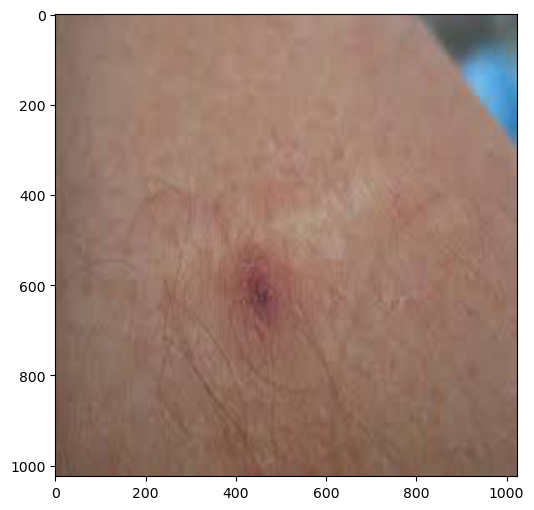

In [11]:
print("Example images")
display_img(example_img)

### Horizontal Flip

In [12]:
def display_img_aug(img, aug, *args, **kwargs):
    """
    Displays input image alongside augmented image.
    
    Parameters
    ----------
    img : np.array
        Original image to augment.
    aug : function
        imgaug.augmenters function to augment img with.
    
    Returns
    -------
    plt.figure
    """
        
    seq = A.Compose([aug(*args, **kwargs)])
    img_aug = seq(image=img)
    images_aug = np.concatenate([np.expand_dims(img, axis=0), np.expand_dims(img_aug["image"], axis=0)])
    
    for img in images_aug:
        display_img(img)

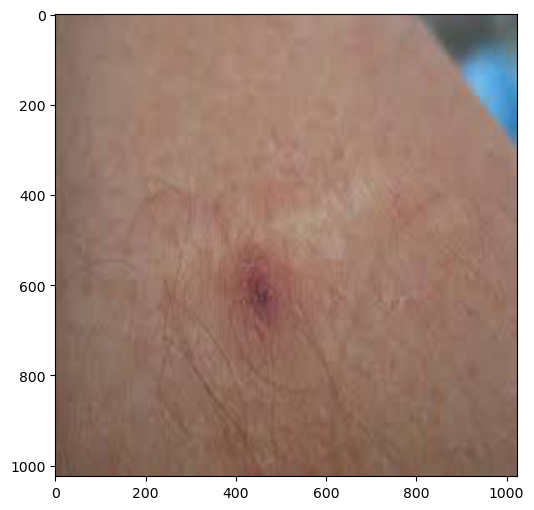

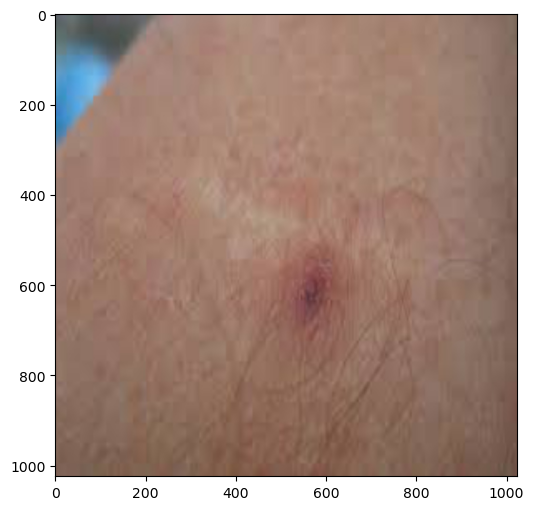

In [13]:
display_img_aug(example_img, A.HorizontalFlip, p=1.0)

### Vertical Flip

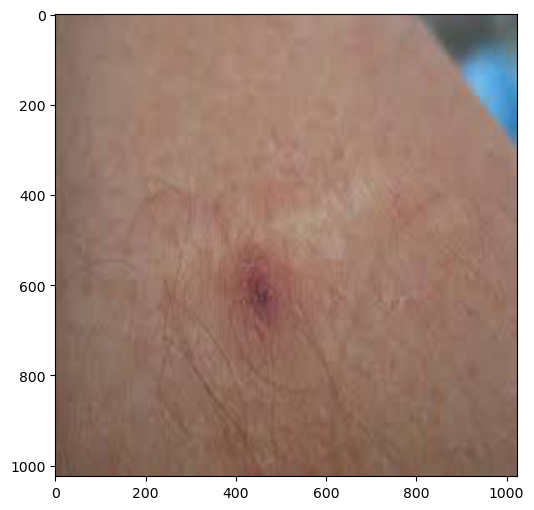

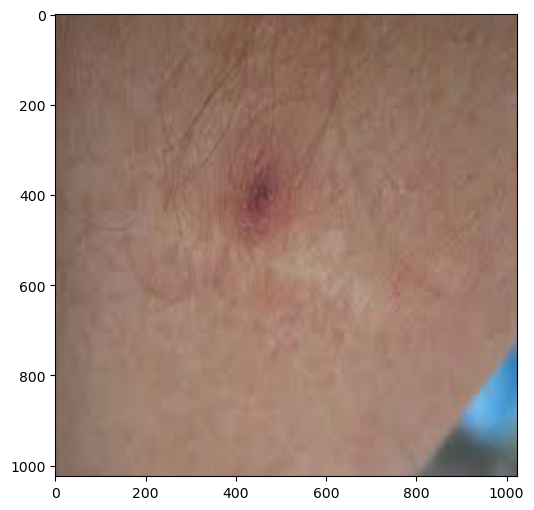

In [14]:
display_img_aug(example_img, A.VerticalFlip, p=1)

### Gaussian Blur

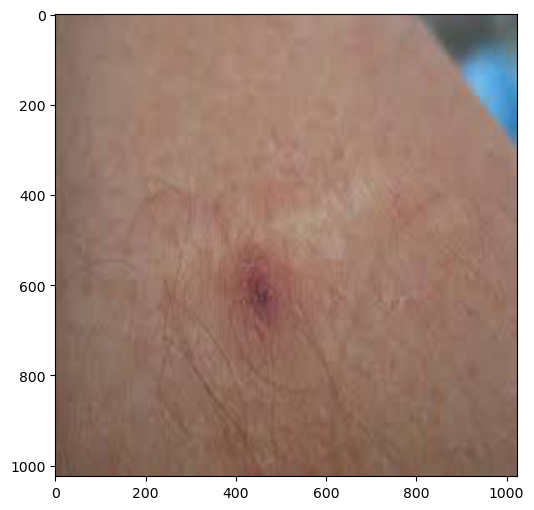

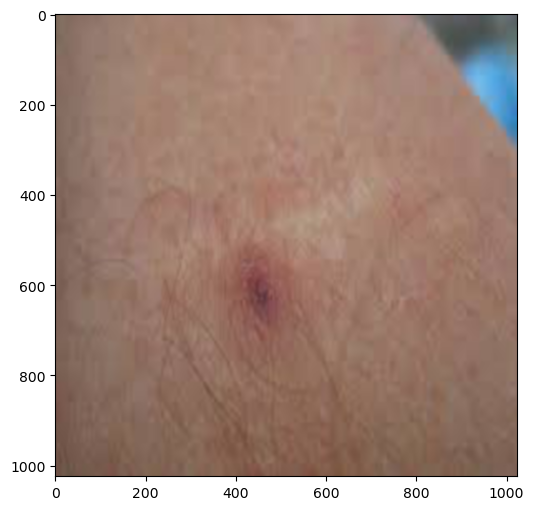

In [15]:
display_img_aug(example_img, A.GaussianBlur, p=1.0, sigma_limit=3)

### MotionBlur

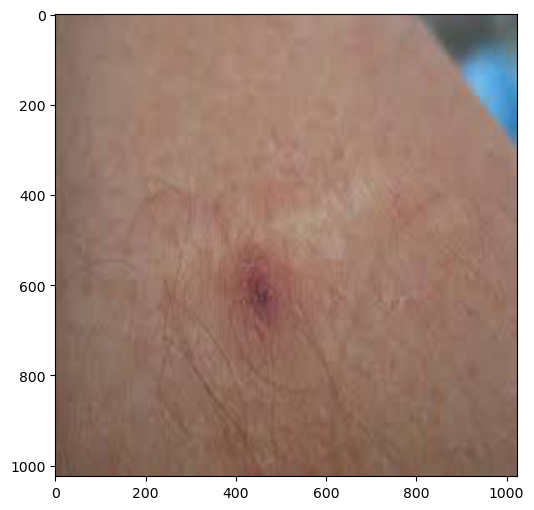

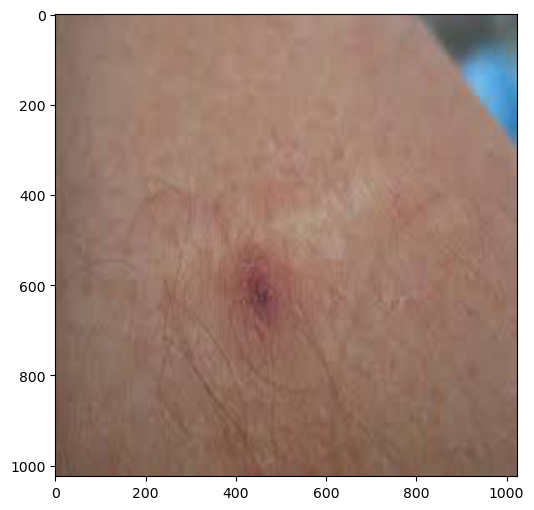

In [16]:
display_img_aug(example_img, A.MotionBlur, blur_limit=7)

### Grayscale

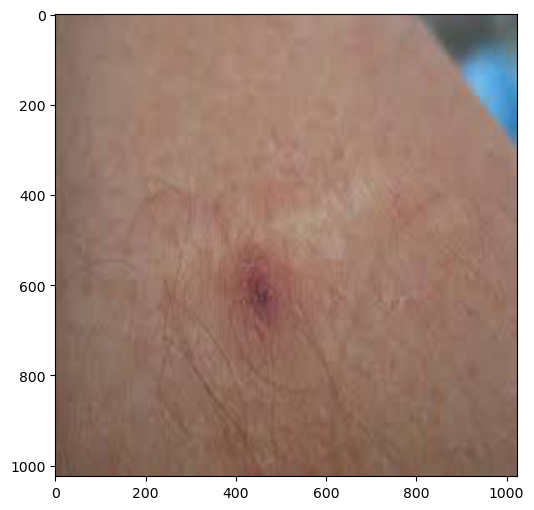

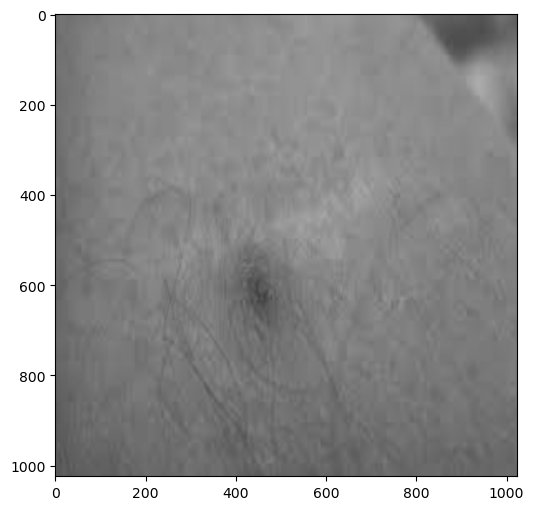

In [17]:
display_img_aug(example_img, A.ToGray, p=1.0)

### Affine

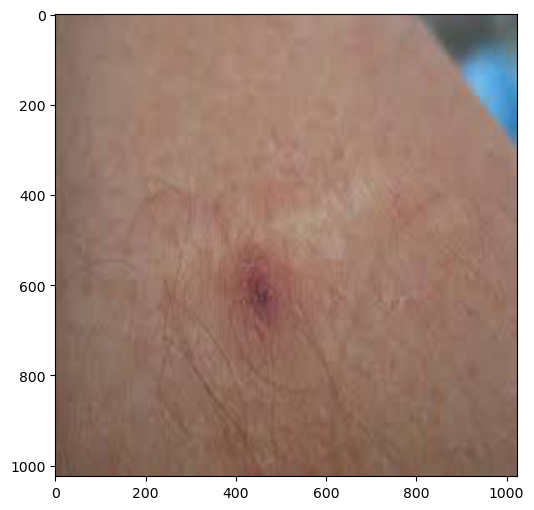

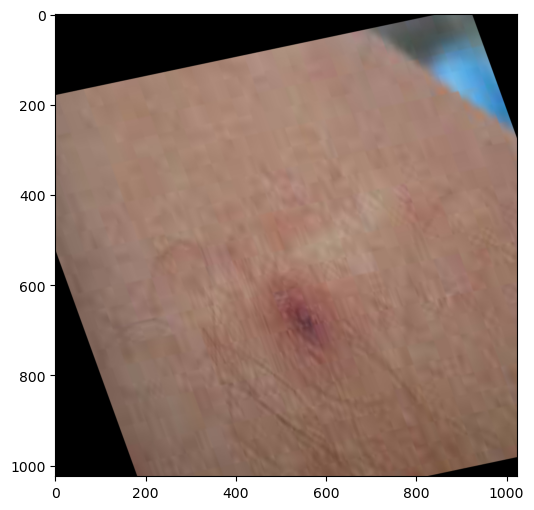

In [18]:
display_img_aug(example_img, A.Affine, p=1.0)

### Pixel Dropout

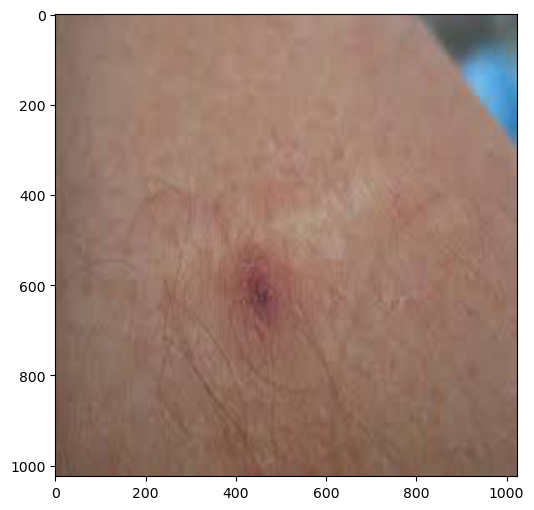

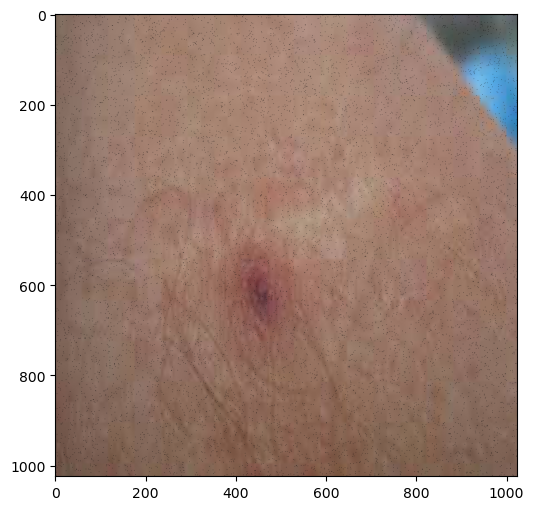

In [19]:
display_img_aug(example_img, A.PixelDropout, p=1.0)

### Coarse Dropout

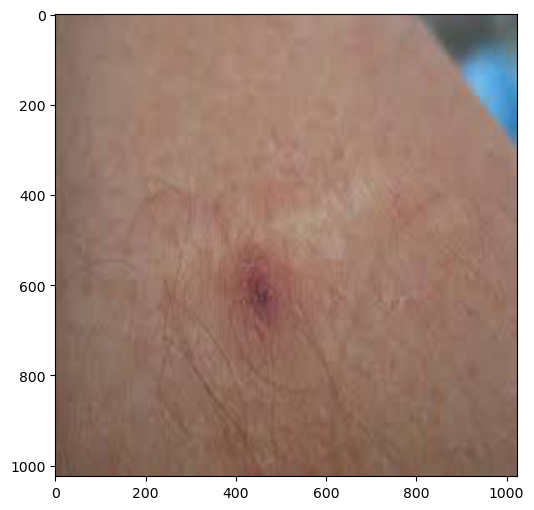

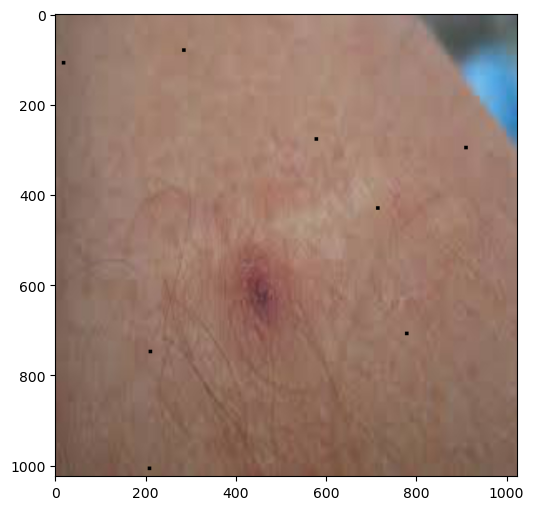

In [20]:
display_img_aug(example_img, A.CoarseDropout, p=1.0)